<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_11/s11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download our code repository and install python dependencies

In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!git clone "https://github.com/jyanivaddi/dl_hub.git"
!git pull
!pip install torchinfo
!pip install prettytable
!pip install torch_lr_finder
!pip install grad-cam

Cloning into 'ERA_V1'...
remote: Enumerating objects: 913, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 913 (delta 40), reused 25 (delta 7), pack-reused 821
Receiving objects: 100% (913/913), 14.68 MiB | 7.80 MiB/s, done.
Resolving deltas: 100% (485/485), done.
fatal: not a git repository (or any of the parent directories): .git
Cloning into 'dl_hub'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 90 (delta 41), reused 65 (delta 22), pack-reused 0
Receiving objects: 100% (90/90), 17.70 KiB | 8.85 MiB/s, done.
Resolving deltas: 100% (41/41), done.
fatal: not a git repository (or any of the parent directories): .git
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) 

Add all the imports:

In [17]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_11")
sys.path.append("dl_hub")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from dl_hub.main import setup_model,build_model
from dl_hub.utils.utils import model_summary, get_incorrect_predictions, generate_grad_cam_visualizations
from dl_hub.utils.vis_utils import show_incorrect_predictions, plot_statistics, plot_losses, plot_accuracy, plot_lr_values, show_incorrect_predictions, plot_image_grid, preview_images, print_train_log

Define Albumentations image augmentations. We use RandomResizedCrop, HorizontalFlip, and cutout

In [4]:
train_transforms = A.Compose(
    [
        AA.crops.transforms.RandomResizedCrop(height = 32,width = 32,p=0.2),
        A.HorizontalFlip(p=0.2),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=8,
                                                max_width=8, min_holes = 1,
                                                min_height=8, min_width=8,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),

        A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
        ToTensorV2(),
    ]
)
test_transforms = A.Compose([

    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
    ToTensorV2(),
])

In [5]:
optimizer_type = 'SGD'
optimizer_params = {
    'weight_decay': 5e-4,
    'lr': 0.01,
    'momentum': 0.9
}
scheduler_type = 'ReduceLrOnPlateau'
scheduler_params = {
    'mode': 'min',
    'factor': 0.1,
    'patience': 4,
    'threshold': 0.1
}
loss_func = nn.CrossEntropyLoss()

Define Parameters

In [6]:
params = {}
params['model_type'] = 'RESNET18'
params['dataset_name'] = 'CIFAR10'
params['batch_size'] = 512
params['train_transforms'] = train_transforms
params['test_transforms'] = test_transforms
params['num_workers'] = 2
params['num_epochs'] = 1
params['optimizer_type'] = optimizer_type
params['optimizer_params'] = optimizer_params
params['scheduler_type'] = scheduler_type
params['scheduler_params'] = scheduler_params
params['loss_func'] = loss_func

Set Up Model

In [7]:
device, train_loader, test_loader, class_names, model, optimizer, scheduler = setup_model(params)

100%|██████████| 170498071/170498071 [00:13<00:00, 12831667.10it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


Show sample Images from the dataset

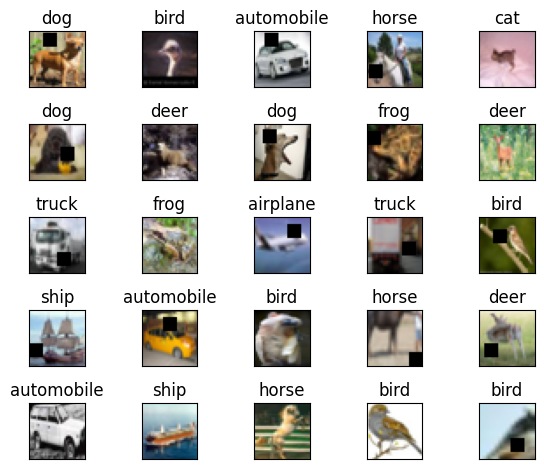

In [15]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Model Summary

In [16]:
model_summary(model, input_size = (3,32,32))

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
ResNet                                   --                        [1, 3, 32, 32]            [1, 10]                   --                        --
├─Conv2d: 1-1                            [3, 3]                    [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     1,769,472
├─BatchNorm2d: 1-2                       --                        [1, 64, 32, 32]           [1, 64, 32, 32]           128                       128
├─Sequential: 1-3                        --                        [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    └─BasicBlock: 2-1                   --                        [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    │    └─Conv2d: 3-1                  [3, 3]                    [1, 64, 32, 32]           [1, 

Build the Model

In [8]:
train_losses, test_losses, train_acc, test_acc, lr_values = build_model(model, device, train_loader, test_loader, optimizer, scheduler, params)

epoch: 1	 learning rate: 0.01


loss=1.367578387260437 batch_id=97 Accuracy = 40.58: 100%|██████████| 98/98 [00:48<00:00,  2.03it/s]



Test set: Average loss: 0.0028, Accuracy: 4989/10000 (49.89%)



Get Incorrect Predictions

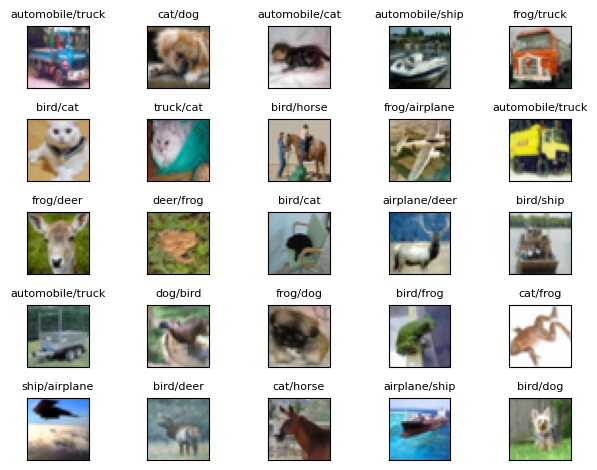

In [11]:
num_rows = 5
num_cols = 5
incorrect_predictions = get_incorrect_predictions(model, test_loader, device)
show_incorrect_predictions(incorrect_predictions, class_names, num_rows, num_cols)

Grad Cam Visualization

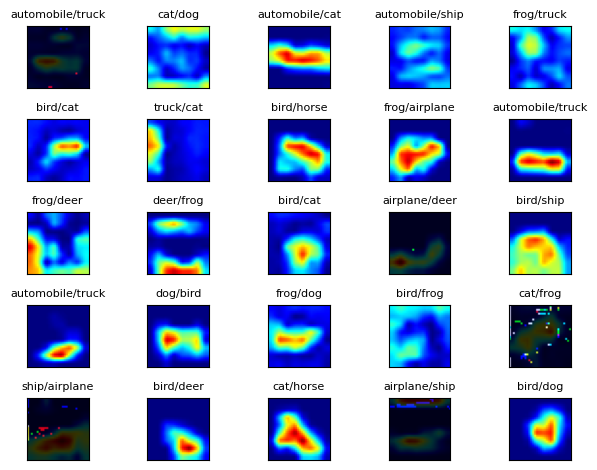

In [13]:
target_layers = [model.layer3[-1]]
num_rows = 5
num_cols = 5
num_images_to_compute = num_rows*num_cols
grad_cam_map_list, prediction_list, ground_truth_list = generate_grad_cam_visualizations(model, target_layers, incorrect_predictions, class_names, num_images_to_compute=num_images_to_compute, image_weight=0.8)
plot_image_grid(grad_cam_map_list, prediction_list, ground_truth_list, num_rows, num_cols)

Plot LR values

Plot results for Batch Norm experiment

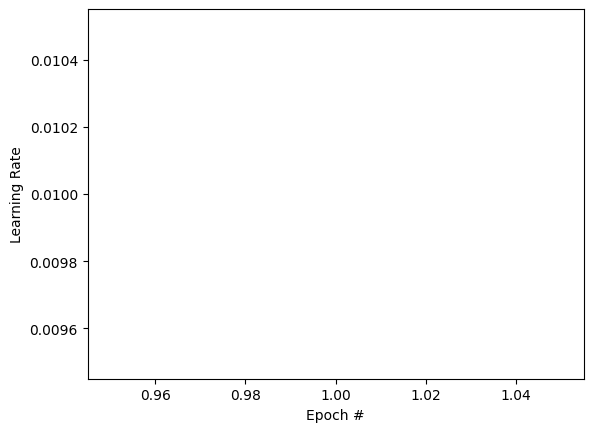

IndexError: ignored

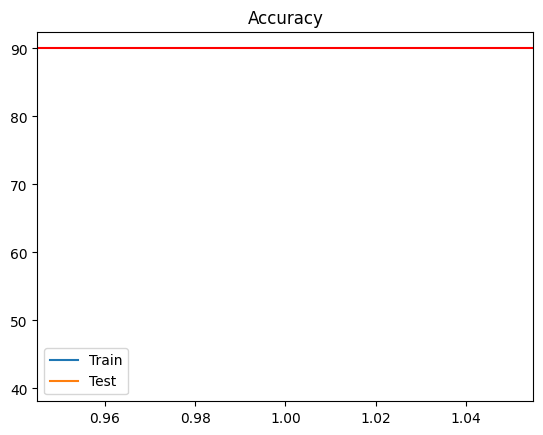

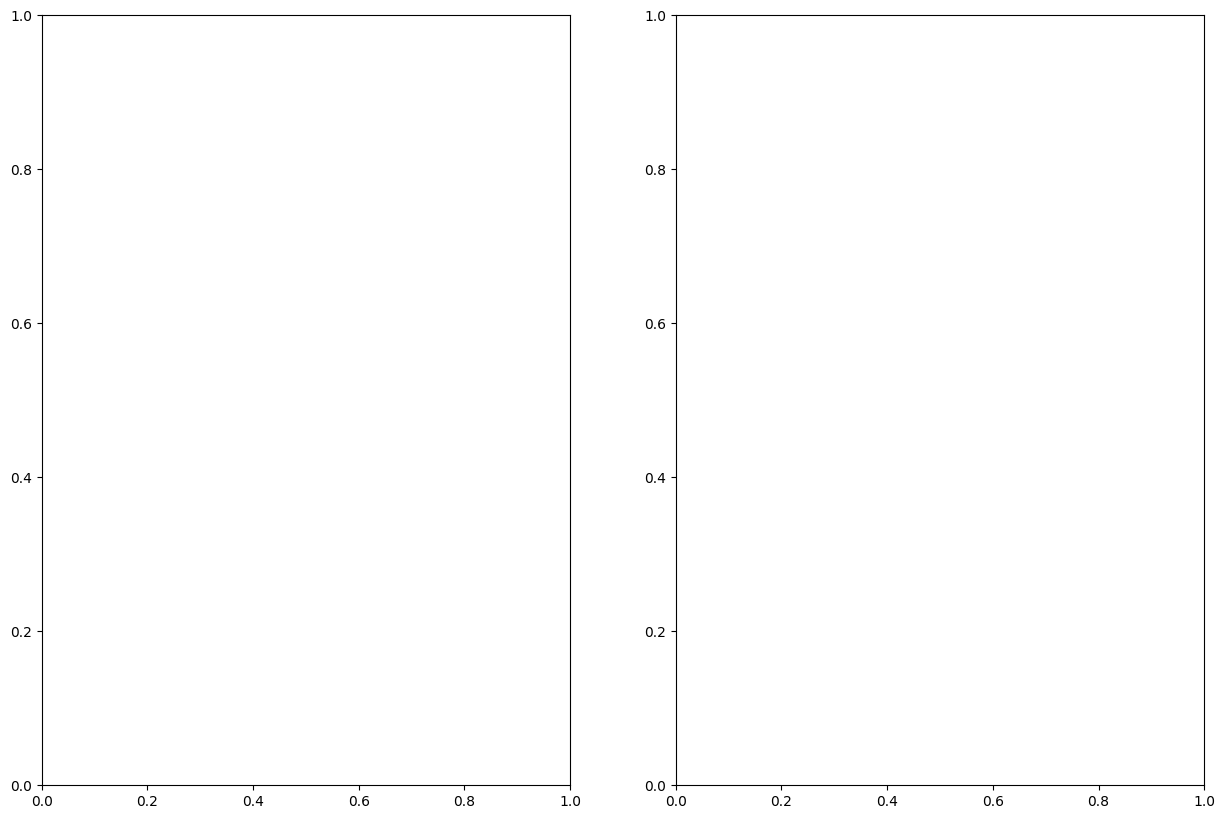

In [19]:
plot_lr_values(lr_values)
#plot_losses(train_losses, test_losses)
plot_accuracy(train_acc, test_acc, target_test_acc=90.)
plot_statistics(train_losses, train_acc, test_losses, test_acc, target_test_acc=90.)


Print Training Log

In [18]:
print_train_log(train_acc, test_acc, train_losses, test_losses)

+-------+--------------------+----------------------+----------------+--------------+
| Epoch |     Train loss     |       Val loss       | Train Accuracy | Val Accuracy |
+-------+--------------------+----------------------+----------------+--------------+
|   1   | 1.6132407066773395 | 0.002822019410133362 |     40.58      |    49.89     |
+-------+--------------------+----------------------+----------------+--------------+
